In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_multigroup_params, load_params
from multi_group_simulation import MultiGroupSimulation
import datetime
import pandas as pd
from dynamic_population_sim_time_varying import DynamicPopulationSim

In [2]:
import pprint


In [3]:
base_params_free = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_post_movein_private.yaml')[1]
base_params_selfiso = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../src/simulations_v2/params/jan4calibration/faculty_staff_pre_semester_private.yaml')[1]

C:\Users\briliu\Desktop\Cornell Outside Infection\group-testing-master/src/simulations_v2\load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
C:\Users\briliu\Desktop\Cornell Outside Infection\group-testing-master/src/simulations_v2\load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [4]:
base_params_post_movein

{'severity_prevalence': array([0.47808584, 0.50907724, 0.00940271, 0.00343422]),
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'mild_symptoms_daily_self_report_p': 0,
 'cases_isolated_per_contact': 0.255,
 'cases_quarantined_per_contact': 2.5,
 'contact_trace_testing_frac': 1,
 'contact_tracing_delay': 1,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'daily_outside_infection_p': 2.

In [5]:
outside_infection_week = pd.read_csv('outside_infection_staff.csv')
outside_infection_week = outside_infection_week.drop('Unnamed: 0', axis = 1)

weeks = list(outside_infection_week['week'].values)
cases = [0,
0,
0,
0,
1,
0,
0,
4,
7,
1,
9,
6,
9,
14,
12,
23,
22,
19,
23,
12]

# quick patch since last week is january
import datetime
print(datetime.datetime(2021,1,4).isocalendar()[1])

weeks.append(1)
cases.append(22)
outside_infection_week = pd.DataFrame(np.column_stack((weeks,cases)), columns = ['week','new_weekly_cases'])
outside_infection_week['new_weekly_cases'] = outside_infection_week['new_weekly_cases']/(7*(10283))
outside_infection_week

1


,week,new_weekly_cases
0,34,0.000000
1,35,0.000000
2,36,0.000000
3,37,0.000000
4,38,0.000014
5,39,0.000000
6,40,0.000000
7,41,0.000056
8,42,0.000097
9,43,0.000014


In [6]:
from analysis_helpers import binomial_exit_function
base_params_selfiso['population_size'] = 0
base_params_free['population_size'] = 10283 
base_params_free['test_population_fraction'] = 0 
base_params_free['test_protocol_QFNR'] =.43
# data analysis shows 106 non-"arrival" positives during movein period
# 33 of these were found b/c of symptoms or surveillance
#base_params_free['cases_isolated_per_contact'] = (106 - 33) / 33 
base_params_post_movein['test_population_fraction'] =0.098 #weighted average for students, weighted average for faculty and staff
base_params_free['test_protocol_QFNR'] = .43
base_params_free['daily_outside_infection_p'] = 0
base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

init_pop_count = 10283
new_population_counts = [int(count) for count in """0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0""".split('\n')]

movein_contact_matrix = np.matrix(
    [[base_params_free['expected_contacts_per_day'], 0],
    [0, base_params_selfiso['expected_contacts_per_day']]])


def init_movein_sim(transmissions_per_contact, isolations_per_trace=None, outside_infection_week = None):
    avg_init_cases = 0
    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)
    base_params = base_params_free.copy()
    init_exposed =  np.random.binomial(init_pop_count, infxn_prob)
    base_params['initial_E_count'] = init_exposed
    base_params['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['outside_infection_p_array'] = outside_infection_week
    
    if isolations_per_trace != None:
        base_params_free['cases_isolated_per_contact'] = isolations_per_trace
        base_params_post_movein['cases_isolated_per_contact']=isolations_per_trace
    free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
        
    dynamic_pop_sim = DynamicPopulationSim(
        base_params,
        base_params_selfiso,
        base_params_post_movein,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        {}
    )
    return dynamic_pop_sim

In [7]:
#private

actuals = pd.read_csv('https://raw.githubusercontent.com/peter-i-frazier/group-testing/master/src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')
actual_counts = actuals['cum_case_count']
len(actual_counts)



148

In [8]:
actual_counts

0        0
1        0
2        0
3        0
4        0
      ... 
143    222
144    236
145    237
146    244
147    246
Name: cum_case_count, Length: 148, dtype: int64

Text(0.5, 1.0, 'Faculty and Staff Case Counts')

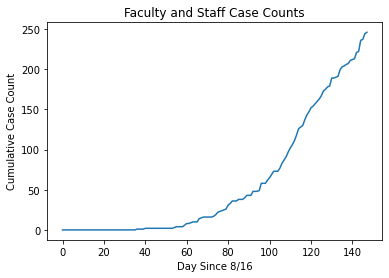

In [9]:
#subtract to center 0,0

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(actual_counts)), actual_counts)
plt.xlabel('Day Since 8/16')
plt.ylabel('Cumulative Case Count')
plt.title('Faculty and Staff Case Counts')

In [10]:
## Evaluating the simulator off a _ day horizon

len(actual_counts)

148

In [11]:
import pandas as pd

def sample_movein_trajectory(transmission_p, isos_per_trace=None,outside_infection_week = None):
    dynamic_pop_sim = init_movein_sim(transmission_p, isos_per_trace,outside_infection_week)
    # for each day
    for i in range(len(actual_counts)-1):
        dynamic_pop_sim.step()
    movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

    
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])

    return list(df['QI'])

def sample_trajectories(transmission_p, ntrajectories, isos_per_trace=None, outside_infection_week = None):
    trajectories = []
    for _ in range(ntrajectories):
        t = sample_movein_trajectory(transmission_p, isos_per_trace,outside_infection_week)
        trajectories.append(t)
    return trajectories


from math import sqrt

def score_trajectories(trajectories):
    avg_
    
    
    
    errors = []
    for t in trajectories:
        error = 0
        for a, b in zip(t, actual_counts):
            error += (a-b)**2
        errors.append(np.log(sqrt(error / len(t))))
    return np.mean(errors)

def score_trajectories1(trajectories):
    errors = []
    for t in trajectories:
        error = 0
        for a, b in zip(t, actual_counts):
            error += (a-b)**2
        errors.append(error / len(t))
    return np.log(np.sqrt(np.mean(errors)))

def score_trajectories_avg(trajectories):
    sse = 0
    avg_traj = np.mean(trajectories,axis = 0)
    for i in range(0,len(avg_traj)):
        sse = sse + (avg_traj[i] - actual_counts[i])**2
    return np.log( np.sqrt(sse/len(avg_traj)))

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_trajectories(trajs, title):
    plt.figure(figsize=(10,6))
    label='Simulated Case Counts'
    for t in trajs:
        plt.plot(range(len(t)), t, color='blue', alpha=0.5, label=label)
        label=None
    plt.plot(range(len(actual_counts)), actual_counts, color='red', linewidth=3, 
             alpha=0.7, label='Observed Case Counts')
    plt.xlabel("Days Since 8/16")
    plt.ylabel('Cumulative Counts')
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

In [13]:
import multiprocessing as mp
import gc
from joblib import Parallel, delayed
import multiprocessing

inputs = np.arange(0.001,.03,.001)
def processInput(i):
    gc.collect()
    trajectories = sample_trajectories(i,400,None,outside_infection_week)
    score = score_trajectories_avg(trajectories)
    return score

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [49]:
results

[4.440534174042731,
 4.430385779242621,
 4.416962394599766,
 4.40467878997624,
 4.387901983883397,
 4.372555820594741,
 4.337370593369568,
 4.313090538967777,
 4.270355266851488,
 4.209392109241423,
 4.126323255039669,
 4.042951868199858,
 3.7815938985642763,
 3.45717939268174,
 2.676329546461861,
 3.3574212096742073,
 4.275091825703226,
 4.919734943306405,
 5.472940053690251,
 5.965135155696468,
 6.448630394826836,
 6.806881374165339,
 7.141160479738499,
 7.38391336180088,
 7.552368082877664,
 7.68231500167771,
 7.794226298693251,
 7.873729548032357,
 7.887215028443565,
 7.952024830627427,
 7.990166594961838,
 8.01520574559845,
 8.05691379941067,
 8.082212192784441,
 8.119610526613156,
 8.143053114108579,
 8.17630135480099,
 8.193928950256728,
 8.222760437226405]

In [50]:
non_log = []
for i in results:
    non_log.append(np.exp(i))

In [51]:
inputs = np.array(inputs)
inputs

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039])

Text(0.5, 1.0, 'Faculty and Staff Callibration')

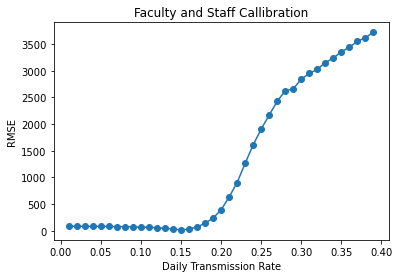

In [52]:
plt.plot(10*inputs,non_log)
plt.scatter(10*inputs,non_log)
plt.xlabel('Daily Transmission Rate')
plt.ylabel('RMSE')
plt.title('Faculty and Staff Callibration')

In [47]:
trajs = sample_trajectories(0.015, ntrajectories,None,outside_infection_week)


NameError: name 'ntrajectories' is not defined

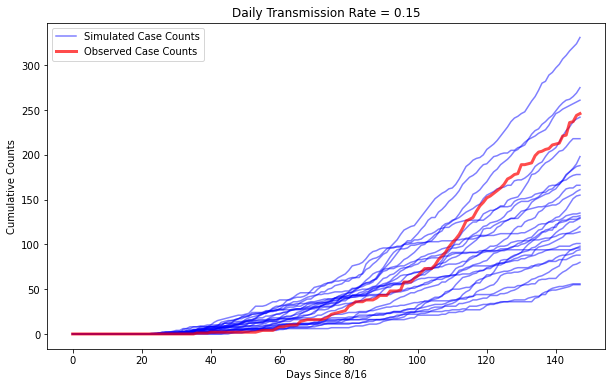

In [29]:
results[transmission_p] = trajs
score = score_trajectories_avg(trajs)
scores[transmission_p] = score
plot_trajectories(trajs, title = 'Daily Transmission Rate = 0.15')
